# Blent : Hyperparameters Optimization

In this nootebook, we will try ot find the best hyperparameters to train the model. Insted of random testing or grid search, we will have a bayesian approach to maximize the score function called __Sequential Model Based Optimisation (SMBO)__. For that, as the score function is to complex to maximize, we will maximize a simpler model (surrogate model) which is a __Tree Of Partzen Estimator (TPE)__. For that we will also use the Expected Improvement (EI) function to find the best point (hyperparam combination) to analyse for the net iterration of the SMBO.

Then we will display the calibration curve to make sure that the threshold we chosed is OK

## Opitimization

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
d = os.getcwd()
df = pd.read_csv(d+"\\data\\sample.csv")

In [3]:
X = pd.read_csv(d+"\\data\\X.csv")
y = pd.read_csv(d+"\\data\\y.csv")

X_train = pd.read_csv(d+"\\data\\X_train.csv")
X_test = pd.read_csv(d+"\\data\\X_test.csv")
y_train = pd.read_csv(d+"\\data\\y_train.csv").values.flatten()
y_test = pd.read_csv(d+"\\data\\y_test.csv").values.flatten()

In [4]:
from lightgbm.sklearn import LGBMClassifier
from hyperopt import hp, tpe, fmin

MODEL_SPECS = {
    "name": "LightGBM",
    "class": LGBMClassifier,
    "max_evals": 20,
    "params": {
        "learning_rate": hp.uniform("learning_rate", 0.001, 1),
        "num_iterations": hp.quniform("num_iterations", 100, 1000, 20),
        "max_depth": hp.quniform("max_depth", 4, 12, 6),
        "num_leaves": hp.quniform("num_leaves", 8, 128, 10),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.3, 1),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "min_child_samples": hp.quniform("min_child_samples", 1, 20, 10),
        "reg_alpha": hp.choice("reg_alpha", [0, 1e-1, 1, 2, 5, 10]),
        "reg_lambda": hp.choice("reg_lambda", [0, 1e-1, 1, 2, 5, 10]),
    },
    "override_schemas": {
        "num_leaves": int, "min_child_samples": int, "max_depth": int, "num_iterations": int
    }
}

C:\Users\saman\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\saman\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\saman\AppData\Local\Continuum\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [26]:
from sklearn.model_selection import RepeatedKFold

def optimize_hyp(instance, training_set, search_space, metric, evals=10):
    # Function to minimize (metric will be minus f1_score)
    def objective(args):
        print(args)
        for param in set(list(MODEL_SPECS["override_schemas"].keys())).intersection(set(args.keys())):
            cast_instance = MODEL_SPECS['override_schemas'][param]
            args[param] = cast_instance(args[param])
            
            
        # Cross Validation
        rep_kfold = RepeatedKFold(n_splits=4, n_repeats=1)
        scores_test = []
        for train_I, test_I in rep_kfold.split(X):
            X_fold_train = X.iloc[train_I, :]
            y_fold_train = y.iloc[train_I]
            X_fold_test = X.iloc[test_I, :]
            y_fold_test = y.iloc[test_I]

            # On entraîne un LightGBM avec les paramètres par défaut
            model = LGBMClassifier(**args, objective="binary", verbose=-1)
            model.fit(X_fold_train, y_fold_train)

            # On calcule le score du modèle sur le test
            scores_test.append(
                metric(y_fold_test, model.predict(X_fold_test))
            )

        return np.mean(scores_test)

    return fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=evals)

In [27]:
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

optimum_params = optimize_hyp(
    MODEL_SPECS['class'],
    training_set=(X_train, y_train),
    search_space=MODEL_SPECS["params"],
    metric=lambda x, y: -f1_score(x, y), # Here is the metric : minus f1_score
    evals=MODEL_SPECS["max_evals"],
)

{'colsample_bytree': 0.6165320835788197, 'learning_rate': 0.36001542730476094, 'max_depth': 12.0, 'min_child_samples': 20.0, 'num_iterations': 640.0, 'num_leaves': 50.0, 'reg_alpha': 2, 'reg_lambda': 0, 'subsample': 0.5045024417273205}
{'colsample_bytree': 0.848125050193651, 'learning_rate': 0.949979611093826, 'max_depth': 6.0, 'min_child_samples': 10.0, 'num_iterations': 160.0, 'num_leaves': 50.0, 'reg_alpha': 5, 'reg_lambda': 2, 'subsample': 0.6285019111256439}
{'colsample_bytree': 0.8035327729390789, 'learning_rate': 0.2614838641815695, 'max_depth': 6.0, 'min_child_samples': 0.0, 'num_iterations': 640.0, 'num_leaves': 90.0, 'reg_alpha': 5, 'reg_lambda': 5, 'subsample': 0.9460472392495558}
{'colsample_bytree': 0.5979144760151137, 'learning_rate': 0.962759587793921, 'max_depth': 12.0, 'min_child_samples': 20.0, 'num_iterations': 560.0, 'num_leaves': 100.0, 'reg_alpha': 10, 'reg_lambda': 0, 'subsample': 0.9516272164979152}
{'colsample_bytree': 0.3151183591508425, 'learning_rate': 0.960

In [28]:
optimum_params

{'colsample_bytree': 0.6184196030878234,
 'learning_rate': 0.2191490946282981,
 'max_depth': 6.0,
 'min_child_samples': 20.0,
 'num_iterations': 200.0,
 'num_leaves': 10.0,
 'reg_alpha': 4,
 'reg_lambda': 4,
 'subsample': 0.5513404748843299}

In [29]:
# Now that we have the optimum parameteres we can put them in the model anf train it (before that we make sure
# the parameters are in the right type)
for param in MODEL_SPECS['override_schemas']:
    cast_instance = MODEL_SPECS['override_schemas'][param]
    optimum_params[param] = cast_instance(optimum_params[param])

model = LGBMClassifier(**optimum_params)
model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.6184196030878234,
               learning_rate=0.2191490946282981, max_depth=6,
               num_iterations=200, num_leaves=10, reg_alpha=4, reg_lambda=4,
               subsample=0.5513404748843299)

In [30]:
from sklearn.metrics import recall_score, precision_score

print("F1 Score : {:2.1f}%".format(f1_score(y_test, model.predict(X_test)) * 100))
print("Precision : {:2.1f}%".format(precision_score(y_test, model.predict(X_test)) * 100))
print("Recall : {:2.1f}%".format(recall_score(y_test, model.predict(X_test)) * 100))

F1 Score : 87.7%
Precision : 80.1%
Recall : 96.9%


In [41]:
#Now we put the model in a pickle file

import joblib

joblib.dump(model, os.path.expanduser(d+"\\data\\model.pkl"))

['C:\\Users\\saman\\Documents\\Python\\Blent\\data\\model.pkl']

## Calibration Curve

Finally let's display the calibration curve to make sure what is the adapted threshlod to consider a prob as positive

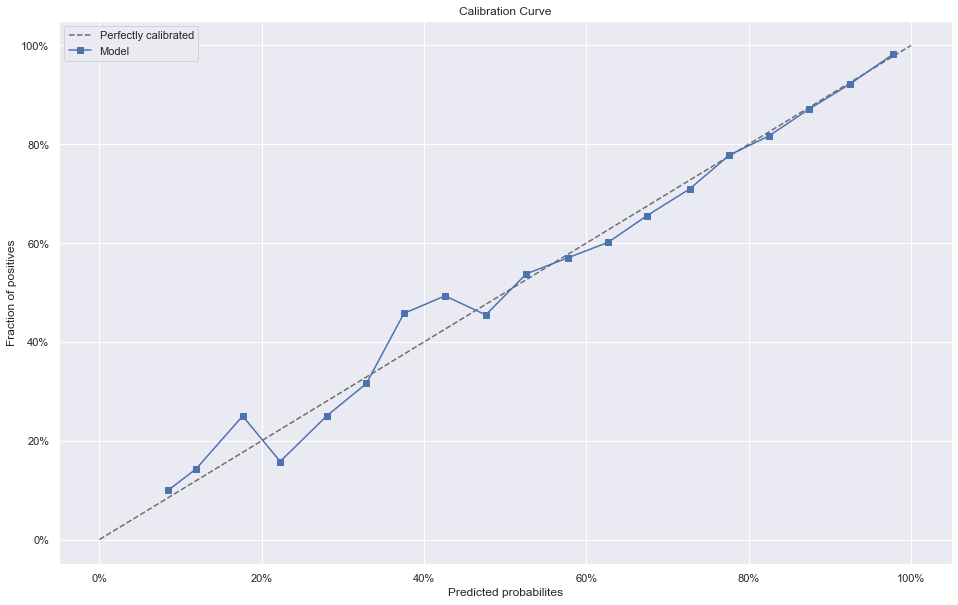

In [40]:
import matplotlib.ticker as mtick

from sklearn.calibration import calibration_curve

prob_pos = model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=20)

plt.figure(figsize=(16, 10))
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated", alpha=0.6)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
plt.ylabel("Fraction of positives")
plt.xlabel("Predicted probabilites")
plt.legend()
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.title("Calibration Curve")
plt.show()

In [33]:
len(prob_pos)

5743

In [34]:
y_test

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)